In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import timedelta

# Цель исследования
- **Изучить поведение пользователей интернет-магазина и особенности работы службы доставки**    
  
Для анализа было предоставлено несколько наборов данных с информацией о пользователях, заказах и товарных позициях, заказанных покупателями. 

### Задачи исследования:
 - Определено число пользователей, совершивших покупку только один раз.
 - Определено среднее число заказов в месяц, которое не доставляется до покупателя. Приведена детализация по причинам.
 - Для каждого товара определено, в какой день недели чаще всего покупается этот товар.
 - Для каждого пользователя определено среднее число покупок в неделю (по месяцам)
 - Проведен когортный анализ пользователей.
 - Построена RFM-сегментация пользователей.

### Характеристика отчета:
- Исследование выполено на языке программирования Python.
- Исследование представляет собой 6 аналитических задач, направленных на изучение аудитории интернет-магазина. В конце аналитического отчета сделаны общие выводы.

In [2]:
# загружаем данные, колонки с датами считаваем в формате дат
customers = pd.read_csv('./olist_customers_dataset.csv')
orders = pd.read_csv('./olist_orders_dataset.csv', parse_dates=[3,4,5,6,7])
items = pd.read_csv('./olist_order_items_dataset.csv', parse_dates=[4])

In [3]:
# таблица с уникальными идентификаторами пользователей
customers.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [4]:
# таблица заказов
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13


In [5]:
# товарные позиции, входящие в заказы
items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


## 1. Сколько пользователей магазина совершили покупку только один раз?
Проанализируем, как отображается время создания заказа, подтверждения, доставки для разных статусов заказа, чтобы принять решение о том, что мы считаем покупкой: для этого **посчитаем число строк, где не зафиксированы даты создания заказа, подтверждения, доставки**

In [6]:
# создаем дф с необходимой информацией о заказах
ord_stat = orders[['order_status',\
                   'customer_id',\
                   'order_purchase_timestamp',\
                   'order_approved_at',\
                   'order_delivered_carrier_date',\
                   'order_delivered_customer_date']]

In [7]:
ord_stat[['order_purchase_timestamp',\
          'order_approved_at',\
          'order_delivered_carrier_date',\
          'order_delivered_customer_date']] = ord_stat[['order_purchase_timestamp',\
                                                        'order_approved_at',\
                                                        'order_delivered_carrier_date',\
                                                        'order_delivered_customer_date']]\
                                                        .isna()

C:\Users\Ekaterina\AppData\Local\Temp\ipykernel_13208\2079393063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ord_stat[['order_purchase_timestamp',\


Получаем таблицу, где `num_orders` - общее число заказов с определенным статусом, остальные колонки - число заказов, для которых отсутствуют определенные подтверждения
- `num_no_purchase_time` - отсутствует время создания заказа
- `num_no_approval_time` - отсутствует время подтверждения оплаты
- `num_no_carrier_date` - отстуствует время передачи заказа в курьерскую службу
- `num_no_customer_date` -  отсутствует время доставки заказа покупателю

In [8]:
ord_stat.groupby('order_status')\
        .agg({'customer_id':'count',\
              'order_purchase_timestamp':'sum',\
              'order_approved_at':'sum',\
              'order_delivered_carrier_date':'sum',\
              'order_delivered_customer_date':'sum'})\
        .rename(columns={'customer_id':'num_orders',\
                        'order_purchase_timestamp':'num_no_purchase_time',\
                        'order_approved_at':'num_no_approval_time',\
                        'order_delivered_carrier_date':'num_no_carrier_date',
                        'order_delivered_customer_date':'num_no_customer_date'})

,num_orders,num_no_purchase_time,num_no_approval_time,num_no_carrier_date,num_no_customer_date
order_status,,,,,
approved,2,0,0,2,2
canceled,625,0,141,550,619
created,5,0,5,5,5
delivered,96478,0,14,2,8
invoiced,314,0,0,314,314
processing,301,0,0,301,301
shipped,1107,0,0,0,1107
unavailable,609,0,0,609,609


В ходе исследования мы **НЕ будем** считать покупками все заказы со статусами `canceled`, `created` (т.к. для них пока не подтверждена оплата) и `unavailable` (товар утерян). Отсутствующие подтверждения оплат и доставки для заказов со статусом `delivered` считаем ошибкой сбора данных.

In [9]:
print("Число строк в файле customers: ", customers.shape[0])
print("Число уникальных пользователей на платформе: ", customers.customer_unique_id.nunique())

Число строк в файле customers:  99441
Число уникальных пользователей на платформе:  96096


В дальнейшем мы еще будем работать только с заказами, которые мы считаем покупкой. Для удобства создадим дф `purchases` для таких заказов.

In [10]:
purchases = orders.query('order_status != "canceled" and order_status != "created" and order_status != "unavailable"')

In [11]:
# объединяем дф с пользователями и покупками
customers_purchases = customers.merge(purchases, how = 'inner', on = 'customer_id')

Для подсчета числа пользователей, совершивших только одну покупку, из объединенной таблицы с пользователями и покупками исключаем пользователей, которые сделали более одного заказа.

In [12]:
print("Число пользователей, которые совершили только одну покупку: ", \
customers_purchases.customer_unique_id.value_counts()\
                  .reset_index()\
                  .query('customer_unique_id == 1')\
                  .customer_unique_id.sum())

Число пользователей, которые совершили только одну покупку:  92099


In [13]:
# определим, какой процент совершившие одну покупку составляют от общего числа пользователей
round(92099/customers.customer_unique_id.nunique()*100,2)

95.84

Расчет показывает, что абсолютное большинство пользователей платформы (95.84%) совершило только одну покупку.

# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
Не доставляются заказы со статусами `canceled` и `unavailable`.  
По каким причинам может быть недоставлен заказ? 
- 1 - не передали покупателю
- 2 - не передали курьеру
- 3 - не подтвержен (считаем, что по вине компании, а не по желанию покупателя)
- 4 - утерян заказ (`unavailable`)

Некоторые заказы, были доставлены, но потом отменены (`canceled`) по желанию покупателя. Их не принимаем в расчет в этом задании

In [14]:
# пример: заказы, которые были отменены по желанию покупателя
orders.query('order_status == "canceled" and not order_delivered_customer_date.isna()').head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30


Создадим датафрейм с заказами, которые не были доставлены до покупателей

In [15]:
undelivered = orders.query('order_status == "canceled" and order_delivered_customer_date.isna() or \
                            order_status == "unavailable"')

In [16]:
undelivered.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

Добавим колонку с месяцами по годам, т.к. у нас в доступе данные за несколько лет

In [17]:
undelivered['month'] = undelivered.order_purchase_timestamp.dt.month
undelivered['year'] = undelivered.order_purchase_timestamp.dt.year
undelivered['purchase_month'] = undelivered.year*12 + undelivered.month

C:\Users\Ekaterina\AppData\Local\Temp\ipykernel_13208\1059114627.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  undelivered['month'] = undelivered.order_purchase_timestamp.dt.month
C:\Users\Ekaterina\AppData\Local\Temp\ipykernel_13208\1059114627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  undelivered['year'] = undelivered.order_purchase_timestamp.dt.year
C:\Users\Ekaterina\AppData\Local\Temp\ipykernel_13208\1059114627.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [18]:
print("Всего за время наблюдения было недоставлено", undelivered.order_id.nunique(),"заказов")

Всего за время наблюдения было недоставлено 1228 заказов


Вычислим, сколько в среднем не доставляется заказов в месяц (без разбивки по причинам)

In [19]:
print("В среднем не доставляется",\
      undelivered.groupby('purchase_month').agg({'order_status':'count'}).order_status.mean().round(),\
      "заказ в месяц")

В среднем не доставляется 51.0 заказ в месяц


Выполним разбивку датасета по причинам и выясним, сколько в среднем не доставляется заказов по каждой и причин

In [20]:
# извлекаем необходимые колонки из дф с недоставленными заказами
undelivered = undelivered.loc[:,['order_approved_at',\
                                 'order_delivered_carrier_date',\
                                 'order_delivered_customer_date',\
                                 'order_status',\
                                 'purchase_month']]

Переведем даты подтверждения оплаты и доставки в булевы значения, чтобы видеть, для каких заказы с подтвержденной оплатой и разные стадии доставки, а также заказы, для которых оплата не была подтверждена

In [21]:
undelivered[['order_approved_at',\
             'order_delivered_carrier_date',\
             'order_delivered_customer_date']] = undelivered[['order_approved_at',\
                                                            'order_delivered_carrier_date',\
                                                            'order_delivered_customer_date']].isna()

Заменим статус заказа на числовое значение для того, чтобы выполнить разбивку по причинам

In [22]:
undelivered['order_status'] = undelivered.order_status.str.replace('unavailable','3')\
                                                            .replace('canceled','0')\
                                                            .astype('int32')

Суммируем информацию о статусах заказов и фактах подтверждения оплаты/доставки - получаем единую колонку, в ней числовые 
значения соответствуют номерам заранее обозначенных причин:
- 1 - не передали покупателю
- 2 - не передали курьеру
- 3 - не подтвержен (считаем, что по вине компании, а не по желанию покупателя)
- 4 - утерян заказ (`unavailable`)

In [23]:
undelivered['reason_score'] = (undelivered['order_status'] +\
                                undelivered['order_approved_at'] +\
                                undelivered['order_delivered_carrier_date'] +\
                                undelivered['order_delivered_customer_date']).replace(5,4)

Группируем дф по месяцам и причинам, считаем общее число недоставленных заказов в каждой группе

In [24]:
month_reasons = undelivered.groupby(['purchase_month','reason_score'], as_index = False)\
                            .agg({'order_status':'count'})\
                            .pivot(index='purchase_month',columns='reason_score',values='order_status')\
                            .fillna(0)

Вычисляем среднее число недоставленных заказов в месяц в группировке по причинам

In [25]:
month_reasons.mean().round(2)

reason_score
1     2.88
2    17.04
3     5.88
4    25.38
dtype: float64

# ОТВЕТ:
- 1 - не передали покупателю: в среднем **2.88** заказов в месяц
- 2 - не передали курьеру: в среднем **17.04** заказов в месяц
- 3 - не подтвержен: в среднем **5.88** заказов в месяц
- 4 - утерян заказ (`unavailable`): в среднем **25.38** заказов в месяц

# 3. В какой день недели чаще всего покупается каждый товар, представленный в магазине?

In [26]:
# дф с товарными позициями, которые содержатся в заказах
items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


Объединим датасеты с информацией о покупках и о заказах. (В первом шаге исследования мы определили, какие заказы мы считаем покупками, а какие - нет)

In [27]:
purchases_items = purchases.merge(items, how='right',on='order_id')

Для того, чтобы определить, в какой день недели товар чаще покупается, мы ориентируемся на время создания заказа, т.к. нас интересует время, когда у покупателя возникает желание приобрести товар.

In [28]:
# создаем колонку с названиями дней недели по дате создания заказа
purchases_items['weekday'] = purchases_items.order_purchase_timestamp.dt.day_name()

In [29]:
purchases_items.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,weekday
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,Wednesday


Определим, в какой день недели товар покупается чаще: для этого посчитаем моду

In [30]:
weekday_mode = purchases_items.loc[:,['product_id','weekday']]\
                                .groupby('product_id')['weekday']\
                                .agg(pd.Series.mode)\
                                .to_frame()
weekday_mode.head(2)

,weekday
product_id,
00066f42aeeb9f3007548bb9d3f33c38,Sunday
00088930e925c41fd95ebfe695fd2655,Tuesday


В датафрейме `weekday_mode` для каждого товара перечислены дни недели, когда этот товар покупается чаще всего. Некоторые товары покупаются одинаково часто в течение нескольких дней недели.

In [31]:
weekday_mode

,weekday
product_id,
00066f42aeeb9f3007548bb9d3f33c38,Sunday
00088930e925c41fd95ebfe695fd2655,Tuesday
0009406fd7479715e4bef61dd91f2462,Thursday
000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...
fff6177642830a9a94a0f2cba5e476d1,"[Saturday, Sunday]"
fff81cc3158d2725c0655ab9ba0f712c,Monday
fff9553ac224cec9d15d49f5a263411f,Friday


# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?    

Датой покупки будем считать дату создания заказа.

In [32]:
print("Первая дата покупки в датасете:", customers_purchases.order_purchase_timestamp.min())
print("Последняя дата покупки в датасете:", customers_purchases.order_purchase_timestamp.max())

Первая дата покупки в датасете: 2016-09-04 21:15:19
Последняя дата покупки в датасете: 2018-09-03 09:06:57


In [33]:
# добавляем колонки с месяцем и годм покупки
customers_purchases['purchase_year'] = customers_purchases.order_purchase_timestamp.dt.year
customers_purchases['purchase_month'] = customers_purchases.order_purchase_timestamp.dt.month

Сделаем группировку: посчитаем общее число заказов для каждого клиента в разбивке по годам и месяцам. Добавляем колонку с числом дней каждого месяца.  
Поскольку 9-ые месяцы 2016 и 2018 годов представлены с датасете не полностью - исключим эти месяцы их расчета, ведь в датасете заведомо содержится информация о меньшем числе покупок в эти месяцы, чем в остальные.

In [34]:
purchases_by_cust_year_month = customers_purchases.query('order_purchase_timestamp >= "2017-01-01" and \
                                                        order_purchase_timestamp < "2018-01-01"')\
                                                    .groupby(['customer_unique_id',\
                                                      'purchase_year',\
                                                      'purchase_month', \
                                                      customers_purchases.order_purchase_timestamp.dt.days_in_month])\
                                                    .agg({'order_id':'count'})\
                                                    .reset_index()\
                                                    .rename(columns = {'order_purchase_timestamp':'days_in_month',\
                                                                       'order_id':'num_orders'})

Посчитаем число недель в каждом месяце

In [35]:
purchases_by_cust_year_month = purchases_by_cust_year_month\
                                                .assign(weeks_in_month = purchases_by_cust_year_month.days_in_month/7)\
                                                .round(2)

Посчитаем среднее число заказов в неделю по месяцам для каждого пользователя

In [36]:
av_purch_in_week = purchases_by_cust_year_month\
                                    .assign(av_purch_in_week = \
                                    purchases_by_cust_year_month.num_orders/purchases_by_cust_year_month.weeks_in_month)

В датафрейме `av_purch_in_week` содержится информация о среднем количестве покупок в неделю по месяцам для каждого клиента (колонка `av_purch_in_week`)

In [37]:
av_purch_in_week.sort_values('av_purch_in_week')

,customer_unique_id,purchase_year,purchase_month,days_in_month,num_orders,weeks_in_month,av_purch_in_week
0,0000f46a3911fa3c0805444483337064,2017,3,31,1,4.43,0.225734
25028,92e7f6715b56ac7e83dc41a81e16cce9,2017,5,31,1,4.43,0.225734
25027,92e2600b1049f75778bc8dc7aababdf8,2017,5,31,1,4.43,0.225734
25026,92e0da7e678f9544ce9a1f6119c0fc20,2017,3,31,1,4.43,0.225734
25025,92e0b708c21b0c3cfb1a3ea8fd807529,2017,5,31,1,4.43,0.225734
...,...,...,...,...,...,...,...
22529,83e7958a94bd7f74a9414d8782f87628,2017,1,31,4,4.43,0.902935
6420,25a560b9a6006157838aab1bdbd68624,2017,4,30,4,4.29,0.932401
30109,b08fab27d47a1eb6deda07bfd965ad43,2017,9,30,4,4.29,0.932401
27642,a239b8e2fbce33780f1f1912e2ee5275,2017,2,28,4,4.00,1.000000


# 5. Когортный анализ пользователей. Какая когорта в период с января по декабрь характеризуется самым высоким retention на 3й месяц?
Будем объединять пользователей в когорты по дате первой покупки.   
Визуализируем распределение числа покупок по месяцам, чтобы понять, с какими когортами будем работать. По графику видим, что полный набор когорт за весь календарный год может быть в 2017 году.

<Axes: xlabel='order_purchase_timestamp', ylabel='Count'>

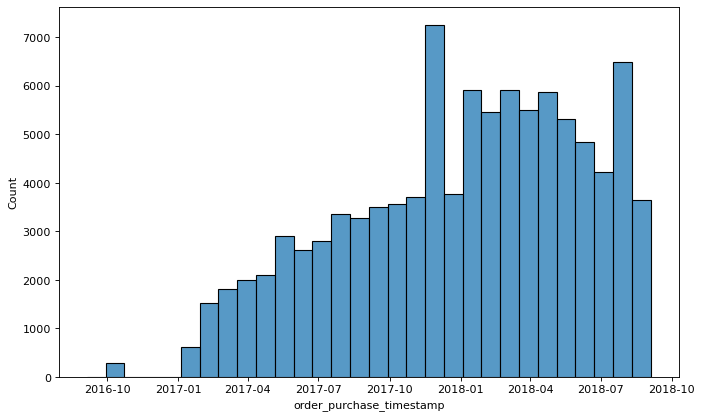

In [38]:
from matplotlib.pyplot import figure
figure(figsize=(10, 6), dpi=80)
sns.histplot(data = purchases, x= 'order_purchase_timestamp', bins = 30)

Необходимо извлечь значения года и месяца из даты создания заказа, т.к. нас интересуют когорты по месяцам.

In [39]:
customers_purchases['order_YM'] = customers_purchases.order_purchase_timestamp.dt.strftime('%Y-%m')

Группируем таблицу по id пользователя для того, чтобы получить год и месяц первого заказа для каждого пользователя

In [40]:
first_orders_YM = customers_purchases.groupby('customer_unique_id')\
                                    .agg({'order_YM' : 'min'})\
                                    .reset_index()\
                                    .rename(columns = {'order_YM':'first_order_YM'})

Добавляем колонку с информацией о месяце первого заказа в таблицу `customers_purchases`

In [41]:
orders_merged = customers_purchases.merge(first_orders_YM, how = 'inner', on = 'customer_unique_id')

Делаем группировку - создаем когорты на основании информации о месяце первого заказа + добавляем даты последующих заказов в этих когортах

In [42]:
cohorts_num_users = orders_merged.groupby(['first_order_YM','order_YM'])\
                                 .agg({'customer_unique_id': pd.Series.nunique})\
                                 .reset_index().rename(columns = {'first_order_YM':'cohort',\
                                                                  'order_YM':'period',\
                                                                  'customer_unique_id':'total_users'})

Вводим нумерацию месяцев покупок для каждой когорты: для этого задаем функцию `cohort_period`

In [43]:
def cohort_period(df):
     df['cohort_period'] = np.arange(len(df)) + 1
     return df
cohorts_num_users = cohorts_num_users.groupby('cohort').apply(cohort_period)
cohorts_num_users.head(2)

C:\Users\Ekaterina\AppData\Local\Temp\ipykernel_13208\1611842596.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  cohorts_num_users = cohorts_num_users.groupby('cohort').apply(cohort_period)


,cohort,period,total_users,cohort_period
0,2016-09,2016-09,2,1
1,2016-10,2016-10,290,1


Меняем индексацию датафрейма с когортами для того, чтобы извлечь информацию об общем числе пользователей в первом месяце каждой из когорт (исходное общее число необходимо для подсчета retention в долях или процентах)

In [44]:
cohorts_num_users = cohorts_num_users.reset_index()\
                                     .set_index(['cohort', 'cohort_period'])\
                                     .drop('index', axis = 1)
cohorts_num_users.head(2)

,,period,total_users
cohort,cohort_period,,
2016-09,1,2016-09,2
2016-10,1,2016-10,290


Посчитаем общее число пользователей в первом месяце каждой из когорт:

In [45]:
cohort_group_size = cohorts_num_users['total_users'].groupby(level=0).first()
cohort_group_size.head()

cohort
2016-09       2
2016-10     290
2016-12       1
2017-01     752
2017-02    1690
Name: total_users, dtype: int64

Посчитаем retention по когортам в долях:

In [46]:
user_retention = cohorts_num_users['total_users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(2)

cohort,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,...,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
cohort_period,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
2,NaN,0.003448,1.0,0.003989,0.002367,0.005056,0.006022,0.004801,0.004513,0.005233,...,0.005565,0.002207,0.003309,0.003619,0.00404,0.005823,0.005162,0.004223,0.005152,0.000161


Транспонируем полученную таблицу с retention.  
  
Для того чтобы увидеть максимальное значение retention на 3 месяц после покупки, сортируем когорты по значениям в 4 месяце (1 месяц не учитываем, т.к. это и есть месяц покупки).  
**Мы видим, что в 2017 году наибольшее значение retention на 3 месяц наблюдалось в когорте 2017-05**

In [47]:
user_retention.T.sort_values(4, ascending=False).head()

cohort_period,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
cohort,,,,,,,,,,,,,,,,,,
2017-05,1.0,0.004801,0.004801,0.003954,0.003106,0.003389,0.004236,0.001412,0.002542,0.002542,0.002542,0.003389,0.002542,0.000282,0.001977,0.002259,NaN,NaN
2017-03,1.0,0.005056,0.003501,0.003890,0.003501,0.001556,0.001556,0.003112,0.003501,0.000778,0.003890,0.001167,0.002334,0.001167,0.001556,0.002334,0.000778,0.001556
2017-06,1.0,0.004513,0.003546,0.003868,0.002579,0.003868,0.003546,0.002257,0.001289,0.002257,0.003224,0.003224,0.001612,0.001289,0.001934,NaN,NaN,NaN
2017-12,1.0,0.002207,0.002759,0.003495,0.002575,0.002023,0.001655,0.000184,0.002207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,0.003448,0.003448,0.003448,0.003448,0.003448,0.003448,0.006897,0.006897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 6. RFM-сегментация пользователей
Кластеризация выпонена по метрикам: 
- **R** - время от последней покупки пользователя до текущей даты, 
- **F** - суммарное количество покупок у пользователя за всё время, 
- **M** - сумма покупок за всё время.   
   
Для каждого RFM-сегмента необходимо предложить границы метрик recency, frequency и monetary.

Объединяем 3 таблицы (`customers`, `purchases` и `items`), т.к. информация о покупателях, времени создания заказов (для показателей recency и frequency) и сумме покупок (monetary), содержится в разных исходных датафреймах.   
  
При построении RFM-сегментации также как и ранее учитываем только заказы, которые мы считаем покупками. Строки из дф `items`, которые относились к прочим заказам также исключаем из сводного дф.

In [48]:
customers_purchases_items = customers_purchases.merge(items, how = 'right', on = 'order_id')\
                                                .query(' not order_status.isna()')
customers_purchases_items.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,order_estimated_delivery_date,purchase_year,purchase_month,order_YM,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,28013.0,campos dos goytacazes,RJ,00010242fe8c5a6d1ba2dd792cb16214,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,...,2017-09-29,2017.0,9.0,2017-09,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,15775.0,santa fe do sul,SP,00018f77f2f0320c557190d7a144bdd3,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,...,2017-05-15,2017.0,4.0,2017-04,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [49]:
# статусы заказов в полученном дф
customers_purchases_items.order_status.unique()

array(['delivered', 'shipped', 'invoiced', 'processing', 'approved'],
      dtype=object)

Сгруппируем данные по заказам, а не по товарам (как было в дф `items`, с которым мы сделали merge)

In [50]:
purchases_price_date = customers_purchases_items.groupby(['customer_unique_id', 'order_id', 'order_purchase_timestamp'],\
                                                   as_index=False)\
                                                .agg({'price':'sum'})
purchases_price_date.head(2)

,customer_unique_id,order_id,order_purchase_timestamp,price
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,129.9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,18.9


Будем проводить анализ пользователей за один год: для этого создадим переменные с "сегодняшней" датой (`now`) - числом на 1 день большим, чем последняя дата в исследуемом датасете, а также переменную 365 дней (`period`) для того, чтобы извлечь из общего  датасета только покупки, сделанные за "последний год"

In [51]:
now = purchases['order_purchase_timestamp'].max() + timedelta(days=1)
period = 365
now

Timestamp('2018-09-04 09:06:57')

Добавим колонку с числом дней, прошедших с даты последнего заказа по "сегодняшнее" число

In [52]:
purchases_price_date['days_since_purchase'] = purchases_price_date['order_purchase_timestamp'].apply(lambda x: (now - x).days)

Оставим строки с покупками, которые были выполнены не позднее, чем год назад, т.к. мы проводим анализ для последнего года

In [53]:
purchases_price_date = purchases_price_date.query('days_since_purchase <= 365')
purchases_price_date.head(2)

,customer_unique_id,order_id,order_purchase_timestamp,price,days_since_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,129.9,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,18.9,119


Создадим колонки со значениями ***recency*** (дата последней покупки), ***frequency*** (число покупок за год) и ***monetary*** (сумма заработанных денег с пользователя) для всех пользователей, которые совершали покупки в течение последнего года

In [54]:
rfm = purchases_price_date.groupby('customer_unique_id', as_index = False)\
                        .agg({'days_since_purchase':'min',\
                              'order_id':'count',\
                              'price':'sum'})\
                        .rename(columns={'days_since_purchase': 'recency', \
                                         'order_id': 'frequency',\
                                         'price':'monetary'})
rfm.head(2)

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.9
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.9


Пользователей необходимо проранжировать по значениям ***recency***, ***frequency*** и ***monetary***. Необходимо получить по 5 рангов для каждой из категорий. Зададим границы рангов по 20%, 40%, 60% и 80% квантилям распределений ***recency***, ***frequency*** и ***monetary*** за последний год

In [55]:
quintiles = rfm[['recency', 'frequency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'recency': {0.2: 75.0, 0.4: 143.0, 0.6: 208.0, 0.8: 279.0},
 'frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.99, 0.8: 179.8}}

По результатам разбиения категорий на квантили мы видим, что такой способ разделения на категории не подходит для метрики ***frequency***. Действительно - ранее мы определили, что около 96% пользователей совершают в магазине только одну покупку. Изучим распределение метрики ***frequency*** подробнее.

In [56]:
rfm.frequency.value_counts().to_frame()

,frequency
1,71240
2,1709
3,96
4,16
5,5
7,3
9,1
11,1


Для метрики ***frequency*** следует подобрать отдельный способ деления на категории. Поскольку эта метрика (суммарное число покупок на пользователя за последний год) имеет значительно меньшую дисперсию, чем метрики ***monetary*** и ***recency*** - разбиение значений на 5 категорий будет избыточным.   
Предлагаю ввести деление на две категории: условно разделим покупателей на "новых" и "постоянных". "Постоянными" будем считать тех, кто совершил более 2 покупок за последний год.

Зададим функции для присвоения рангов, после разбиения recency и monetary по границам квантилей, а также frequency на 2 категории (новые и постоянные покупатели).   
Наилучшие показатели ***recency*** (5 ранг) - это значения, которые оказались меньше квантили 20%, т.к. это пользователи, которые  сделали покупки наиболее недавно. Наилучшие показатели ***monetary*** - это значения, которые оказались больше 80% квантили, т.к. это пользователи, которые сделали большее число покупок за последний год и принесли нам больше денег. Наилучший показатель ***frequency*** (2 ранг) - это наши постоянные покупатели, а именно пользователи, которые совершили более 2-х покупок за последний год.

In [57]:
def r_score(x):
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1

def m_score(x):
    if x <= quintiles['monetary'][.2]:
        return 1
    elif x <= quintiles['monetary'][.4]:
        return 2
    elif x <= quintiles['monetary'][.6]:
        return 3
    elif x <= quintiles['monetary'][.8]:
        return 4
    else:
        return 5
    
def f_score(x):
    if x <= 2:
        return 1
    else:
        return 2

Применям функции - создаем столбцы с присвоенными рангами

In [58]:
rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['monetary'].apply(lambda x: m_score(x))

Складываем ранги по трем шкалам, для каждого пользователя и получаем 3-х значный RFM-score

In [59]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head(2)

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.9,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.9,4,1,1,411


Визуализируем распределение пользователей по сегментам каждой из трех метрик:

In [64]:
def scores(rfm_score):
    r = rfm.R.value_counts().to_frame().reset_index().rename(columns = {'index':'R','R':'Total users'})
    f = rfm.F.value_counts().to_frame().reset_index().rename(columns = {'index':'F','F':'Total users'})
    m = rfm.M.value_counts().to_frame().reset_index().rename(columns = {'index':'M','M':'Total users'})
    return {'R': r,
           'F': f,
           'M': m}

In [66]:
scores = scores(rfm)

In [67]:
def graf(scores):    
    plt.figure(figsize=(20, 9))
    plt.subplot(1, 3, 1)
    plt.ylabel("Total users")
    bar = sns.barplot(x='R', y='Total users', data=scores['R'])
    bar.axes.set_title('Recency')
    plt.subplot(1, 3, 2)
    bar = sns.barplot(x='F', y='Total users', data=scores['F'])
    bar.axes.set_title('Frequency')
    plt.subplot(1, 3, 3)
    bar = sns.barplot(x='M', y='Total users', data=scores['M'])
    bar.axes.set_title('Monetary')

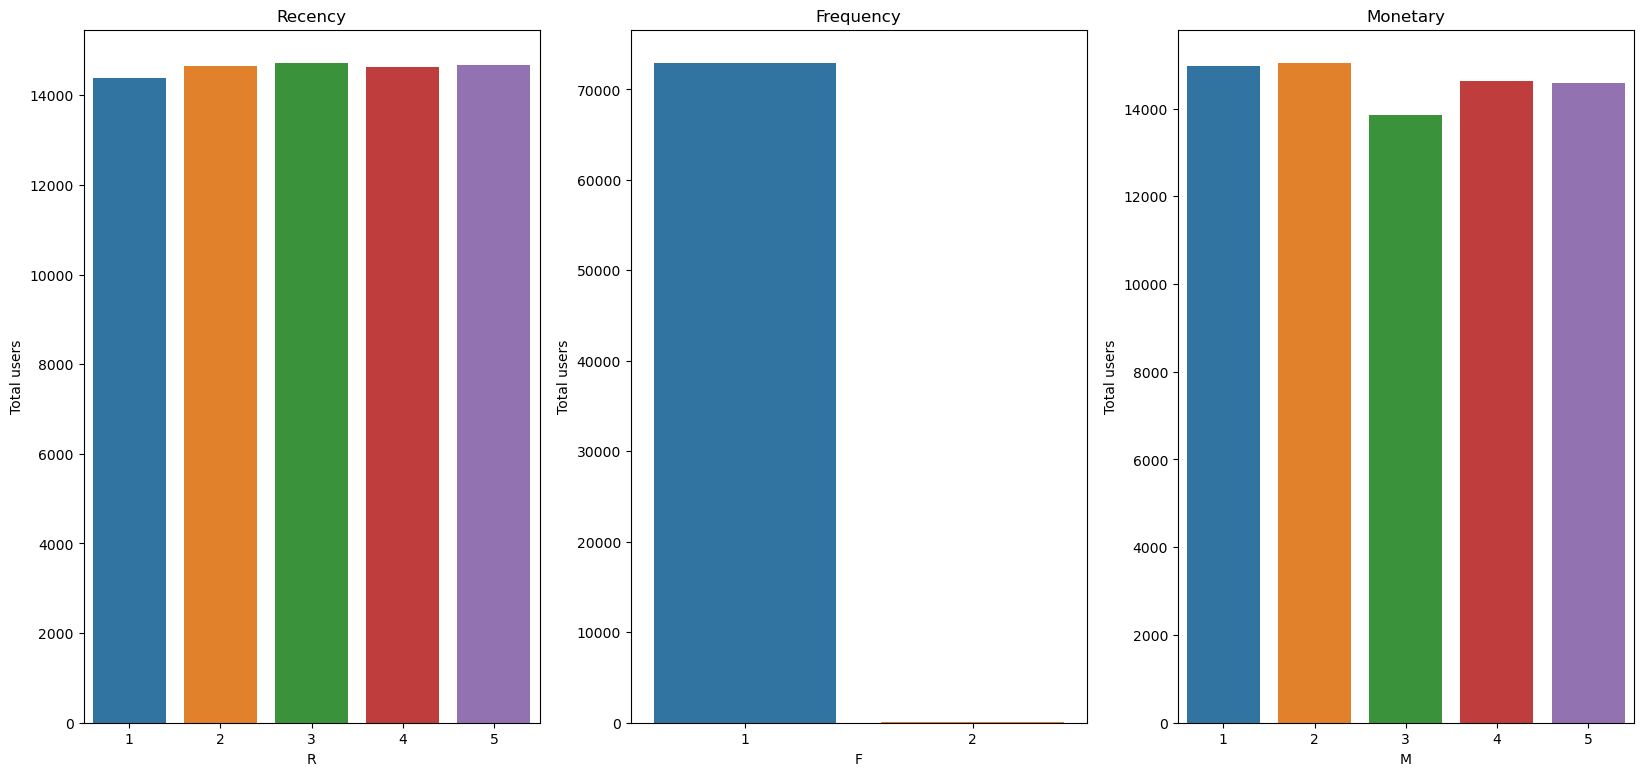

In [68]:
graf(scores)

Мы видим, что покупатели достаточно равномерно распределены по 5-ти кластерам метрик ***recency*** (давность покупки) и ***monetary*** (прибыль), при этом распределение метрики ***frequency*** (частота покупок) очень неравномерно. Преобладающее число клиентов совершает в магазине 1-2 покупки и больше не возвращается. 
Имеет смысл изучить причины низкой возвращаемости клиентов и, возможно, принять меры по ее повышению.